In [2]:
import pandas as pd
import numpy as np
import os 

# plot 
import matplotlib.pyplot as plt
import seaborn as sns

# GMM
from sklearn.mixture import GaussianMixture
# sklearn train test split
from sklearn.model_selection import train_test_split
# import norm
from scipy.stats import norm


# Check if 'has_changed_directory' is defined
if 'has_changed_directory' not in globals():
    # Change the working directory only if it hasn't been changed before
    os.chdir("..")
    # Set the flag to True after changing the directory
    has_changed_directory = True

In [3]:
data_path = os.path.join(os.getcwd(), 'data')

# read data/trait_pred_log.csv
df_trait = pd.read_csv(os.path.join(data_path, 'traits_pred_log.csv'), index_col=0)

# read pred_errors.csv
df_error = pd.read_csv(os.path.join(data_path, 'pred_errors.csv'), index_col=0)


In [4]:
df_trait.columns

Index(['Bark thickness', 'Crown diameter', 'Crown height', 'Leaf K per mass',
       'Leaf N per mass', 'Leaf P per mass', 'Leaf Vcmax per dry mass',
       'Leaf area', 'Leaf density', 'Leaf thickness', 'Root depth',
       'Seed dry mass', 'Specific leaf area', 'Stem conduit diameter',
       'Stem diameter', 'Stomatal conductance', 'Tree height', 'Wood density'],
      dtype='object')

## GMM in 1D

In [ ]:
# # plot the distribution for each df_trait.columns
for col in df_trait.columns:
    # fig size
    plt.figure(figsize=(4, 3))
    sns.histplot(df_trait[col], bins=500)
    plt.title(col)
    plt.show()

# Crown height seems good for 1D GMM

In [114]:
import imageio

# Assuming df_trait is properly defined and has the necessary data
df_crown_height = df_trait[['Crown height']]

# Define a range of alpha values
alpha_values = np.linspace(0.001, 0.3, 300)  # from 0.5% to 10% in 40 steps

images = []  # To hold file paths for images

# Ensure the output directory exists
output_dir = os.path.join(os.getcwd(), 'output', 'dist')
os.makedirs(output_dir, exist_ok=True) 

for ix, alpha in enumerate(alpha_values):
    std_prop = df_crown_height.values * alpha
    df_crown_height_resample = np.random.normal(df_crown_height.values, std_prop)

    # Plot the distribution for the resample
    plt.figure(figsize=(10, 14))
    sns.histplot(df_crown_height_resample, bins=500, kde=False,
                 legend=False, color='coral')
    plt.title(f'Crown height resample: alpha={alpha:.2f}')
    plt.xlabel('Crown Height')
    plt.ylabel('Frequency')
    # set x limits
    plt.xlim(1, 4)
    plt.ylim(0, 600)
    # Save the plot as an image
    # filename = f'.\output\dist_1d\frame_{ix}.png'
    filename = os.path.join(output_dir, f'frame_{ix}.png')
    plt.savefig(filename)
    plt.close()
    images.append(filename)

# Create a GIF
output_gif = os.path.join(os.getcwd(), 'output', 'dist', 'distribution_change.gif')
with imageio.get_writer(output_gif, mode='I', duration=1) as writer:
    for filename in images:
        image = imageio.imread(filename)
        writer.append_data(image)
        # Remove the file after adding it to the GIF to save disk space
        os.remove(filename)

print("GIF created: distribution_change.gif")


C:\Users\pablo\AppData\Local\Temp\ipykernel_14184\1567929331.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created: distribution_change.gif


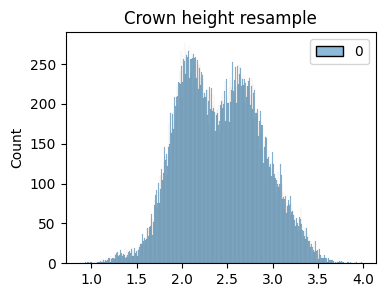

In [23]:
df_crown_height = df_trait[['Crown height']]

# alpha = 0.01

# std_prop = df_crown_height.values * alpha
# use error from df_errors
std_prop = df_error.loc['Crown height', 'pred_error']

# resample each observation with mean its real value and std_prop[i]
df_crown_height_resample = np.random.normal(df_crown_height.values, std_prop*0.5)

df_crown_height_resample

# plot the distribution for the resample
plt.figure(figsize=(4, 3))
sns.histplot(df_crown_height_resample, bins=500)
plt.title('Crown height resample')
plt.show()

# plt.figure(figsize=(4, 3))
# df_crown_height = df_trait[['Crown height']]
# # show distribution of crown height
# sns.histplot(df_crown_height, bins=500)

# df_crown_height = df_crown_height_resample.copy()

In [39]:
# make df_crown_height a sample
# df_crown_height = df_trait[['Crown height']]   #.sample(200)

Number of components: 1, BIC: 61187.40, My BIC: 61187.40
Number of components: 2, BIC: 60050.39, My BIC: 60050.39
Number of components: 3, BIC: 60353.32, My BIC: 60353.32
Number of components: 4, BIC: 60157.80, My BIC: 60157.80
Number of components: 6, BIC: 60073.60, My BIC: 60073.60
Number of components: 8, BIC: 60101.63, My BIC: 60101.63
Number of components: 10, BIC: 60141.63, My BIC: 60141.63
Number of components: 12, BIC: 60175.55, My BIC: 60175.55
Number of components: 14, BIC: 60237.63, My BIC: 60237.63
Number of components: 16, BIC: 60275.47, My BIC: 60275.47


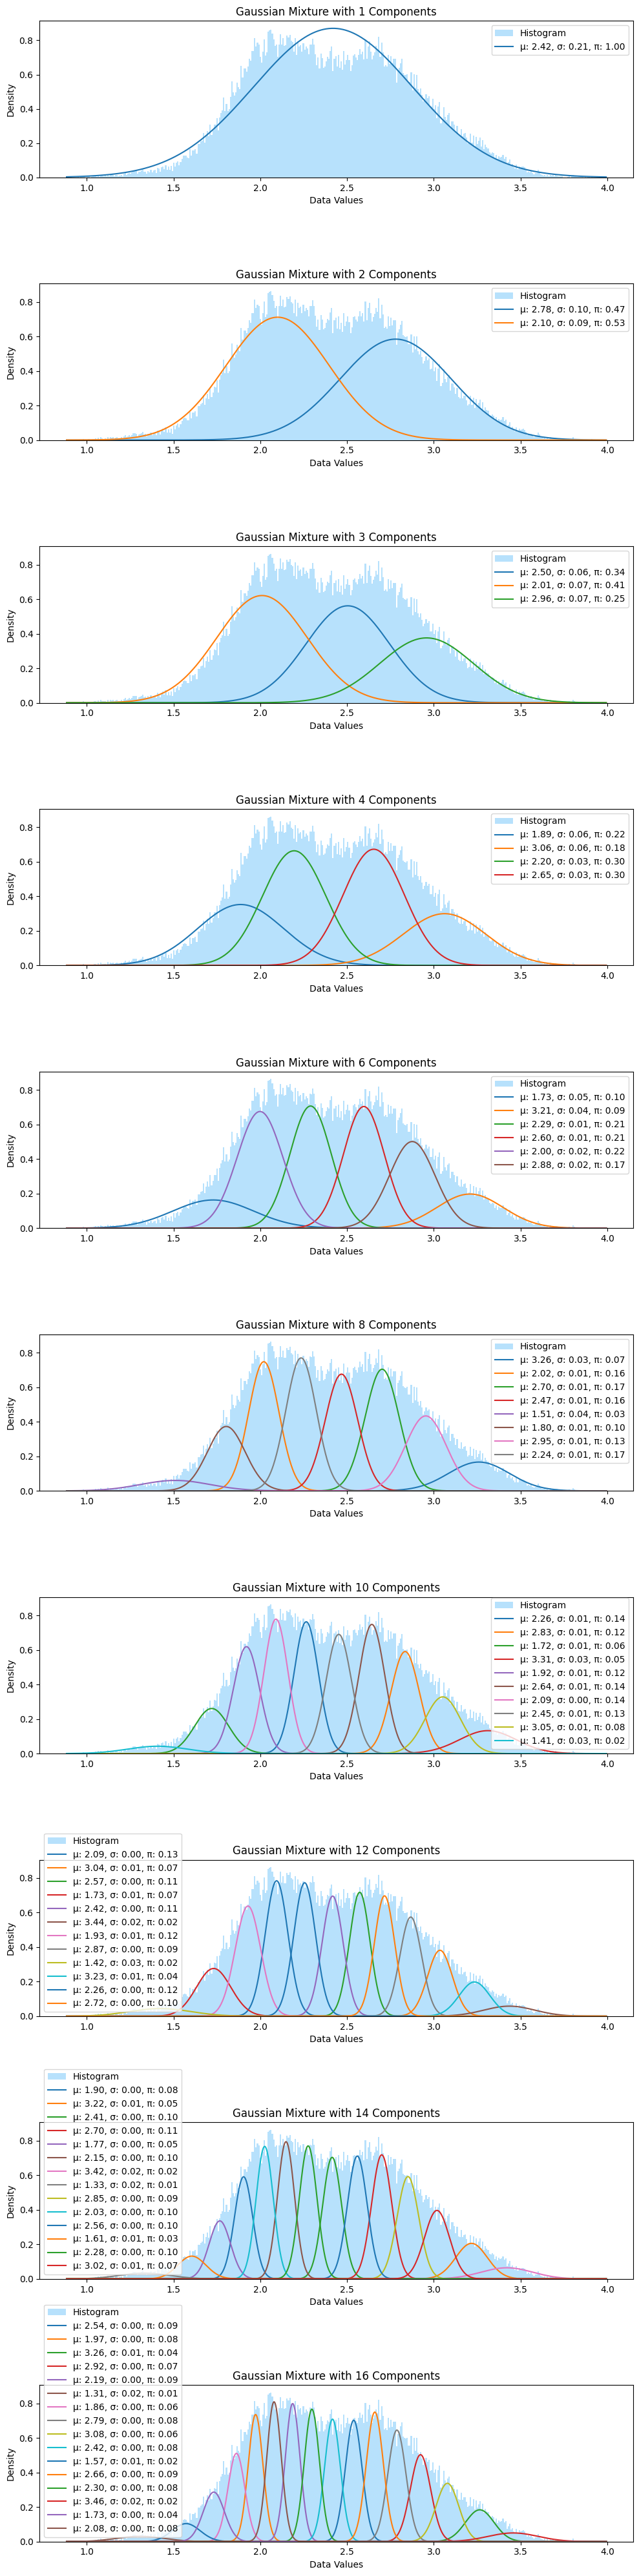

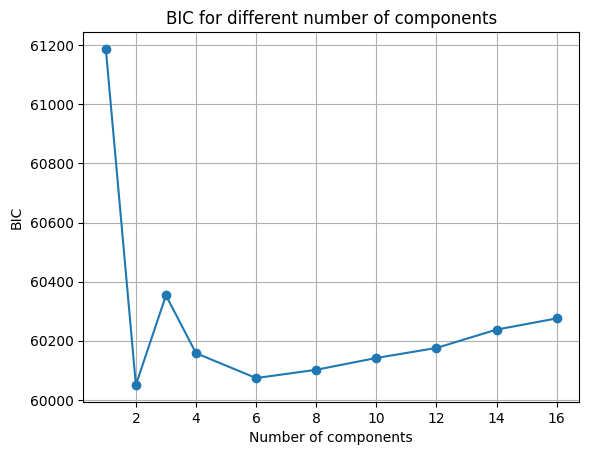

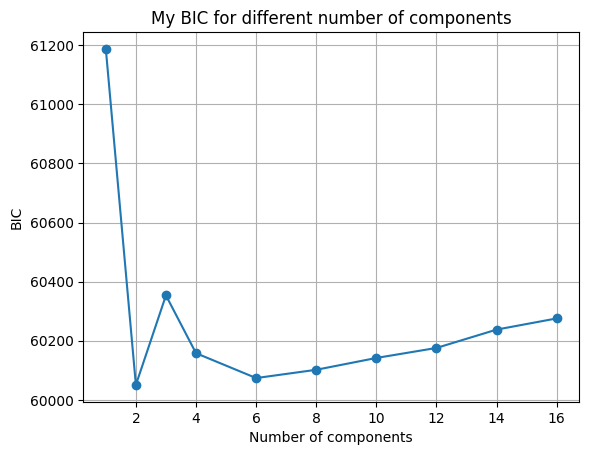

In [27]:
# Number of components to test
components_range = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16]
bic_list = []
my_bic_list = []

n_bins = 400

# alpha = 2
# std_prop = df_trait[['Crown height']].values * alpha
std_prop = df_error.loc['Crown height', 'pred_error']*0.6

# resample each observation with mean its real value and std_prop[i]
df_crown_height = np.random.normal(df_trait[['Crown height']].values, std_prop)



# Prepare a large figure to hold all the subplots
plt.figure(figsize=(10, 4 * len(components_range)))

for i, n_components in enumerate(components_range):
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=0, n_init = 3)
    gmm.fit(df_crown_height)
    
    # BIC for the current model
    bic = gmm.bic(df_crown_height)
    bic_list.append(bic)

    # My BIC (Compare to see if sklearn is correct)
    ll = gmm.score_samples(df_crown_height)
    num_params = 3 * n_components - 1 # 3 parameters for each component, except for the last one (linear dependency)
    my_bic = -2 * np.sum(ll) + num_params * np.log(df_crown_height.shape[0])
    my_bic_list.append(my_bic)

    print(f'Number of components: {n_components}, BIC: {bic:.2f}, My BIC: {my_bic:.2f}')
    
    # Add subplot for current number of components
    ax = plt.subplot(len(components_range), 1, i + 1)
    # hist, bin_edges = np.histogram(df_crown_height, bins=30, density=True)
    ax.hist(df_crown_height, bins=n_bins, density=True, alpha=0.6, color='lightskyblue', label='Histogram')
    
    x = np.linspace(df_crown_height.min(), df_crown_height.max(), 1000)
    for mean, cov, weight in zip(gmm.means_.flatten(), gmm.covariances_.flatten(), gmm.weights_):
        pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
        ax.plot(x, pdf, label=f'μ: {mean:.2f}, σ: {cov:.2f}, π: {weight:.2f}')
    
    ax.set_title(f'Gaussian Mixture with {n_components} Components')
    ax.set_xlabel('Data Values')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

# Plot BIC
plt.figure()
plt.plot(components_range, bic_list, marker='o')
plt.title('BIC for different number of components')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

# Plot my BIC
plt.figure()
plt.plot(components_range, my_bic_list, marker='o')
plt.title('My BIC for different number of components')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.grid(True)
plt.show()


In [59]:

def best_gmm_bic(df_data, n_components_list):
    """Evaluate Gaussian Mixture Models for varying number of components and return the best based on BIC."""
    best_bic = np.inf
    best_n = None
    for n_components in n_components_list:
        gmm = GaussianMixture(n_components=n_components, random_state = 123, n_init=3)
        gmm.fit(df_data)
        bic = gmm.bic(df_data)
        if bic < best_bic:
            best_bic = bic
            best_n = n_components
    return best_n, best_bic


In [ ]:

# Range of alpha values to test
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.06, 0.08, 0.1, 0.2, 0.3]

# Number of components to test
components_range = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

# Original data
df_crown_height = df_trait[['Crown height']].values

# Track the best number of components for each alpha
best_components = []
best_bics = []

# Plotting setup
fig, axes = plt.subplots(len(alpha_values), 1, figsize=(10, 4 * len(alpha_values)))

for ix, alpha in enumerate(alpha_values):
    std_prop = df_crown_height * alpha
    df_crown_height_resampled = np.random.normal(df_crown_height, std_prop)

    # Get the best number of components for the current alpha
    best_n, best_bic = best_gmm_bic(df_crown_height_resampled, components_range)
    best_components.append(best_n)
    best_bics.append(best_bic)

    # Plotting the best case
    gmm = GaussianMixture(n_components=best_n, random_state=0, n_init=3)
    gmm.fit(df_crown_height_resampled)
    ax = axes[ix]
    ax.hist(df_crown_height_resampled, bins=400, density=True, alpha=0.6, color='lightskyblue', label='Histogram')
    x = np.linspace(df_crown_height_resampled.min(), df_crown_height_resampled.max(), 1000)
    for mean, cov, weight in zip(gmm.means_.flatten(), gmm.covariances_.flatten(), gmm.weights_):
        pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
        ax.plot(x, pdf, label=f'μ: {mean:.2f}, σ: {cov:.2f}, π: {weight:.2f}')
    ax.set_title(f'Best GMM with {best_n} Components for Alpha={alpha:.3f}')
    ax.set_xlabel('Data Values')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

# Plot alpha vs the best number of components
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, best_components, marker='o', linestyle='-', color='b')
plt.title('Best Number of Components vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('Best Number of Components')
plt.grid(True)
plt.show()

In [76]:
import imageio

# Assuming df_trait is properly defined and has the necessary data
# df_crown_height = df_trait[['Crown height']]
trait = 'Leaf thickness'
# get xlims
xlims = (df_trait[trait].min()- 0.5, df_trait[trait].max()+0.5)

# Define a range of alpha values
# alpha_values = [0, 0.1, 0.2, 0.3, 0.4, .43, 
#                 .47, .5, .57, .65, 0.7, 0.75, 1, 1.5, 2]
alpha_values = [0, 0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 4]

images = []  # To hold file paths for images

# Ensure the output directory exists
output_dir = os.path.join(os.getcwd(), 'output', 'dist')
os.makedirs(output_dir, exist_ok=True) 

n_components_list = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 16]

for ix, alpha in enumerate(alpha_values):
    # std_prop = df_crown_height.values * alpha
    std_prop = df_error.loc[trait, 'pred_error']
    df_trait_resampled = np.random.normal(df_trait[[trait]].values, std_prop*alpha)

    best_n = best_gmm_bic(df_trait_resampled, n_components_list)[0]

    print(f'Best number of components for alpha={alpha}: {best_n}')


    # Plotting the best case
    gmm = GaussianMixture(n_components=best_n, random_state=0, n_init=3)
    gmm.fit(df_trait_resampled)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.hist(df_trait_resampled, bins=500, density=True, alpha=0.6, color='lightskyblue')
    x = np.linspace(df_trait_resampled.min(), df_trait_resampled.max(), 1000)
    for mean, cov, weight in zip(gmm.means_.flatten(), gmm.covariances_.flatten(), gmm.weights_):
        pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
        ax.plot(x, pdf)
    ax.set_title(f'Std error: {np.round(std_prop, 4)}*{alpha} = {np.round(std_prop* alpha, 6)}')
    ax.set_xlabel(trait)
    ax.set_ylabel('Density')
    # set limits
    # ax.set_xlim(0.5, 5)
    # set x limits to limits from the data
    ax.set_xlim(xlims)
    ax.set_ylim(0, 2)

    filename = os.path.join(output_dir, f'frame_{ix+1}.png')
    plt.savefig(filename)
    plt.close()
    images.append(filename)

# Create a GIF
output_gif = os.path.join(os.getcwd(), 'output', 'dist', f'GMM_resample_{trait}.gif')
with imageio.get_writer(output_gif, mode='I', fps = 1) as writer:
    for filename in images:
        image = imageio.imread(filename)
        writer.append_data(image)
        # Remove the file after adding it to the GIF to save disk space
        # os.remove(filename)

print("GIF created: distribution_change.gif")


Best number of components for alpha=0: 16
Best number of components for alpha=0.1: 16
Best number of components for alpha=0.2: 16
Best number of components for alpha=0.5: 12
Best number of components for alpha=0.7: 2
Best number of components for alpha=1: 2
Best number of components for alpha=1.5: 10
Best number of components for alpha=2: 7
Best number of components for alpha=4: 1


C:\Users\pablo\AppData\Local\Temp\ipykernel_20344\379464697.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created: distribution_change.gif


In [ ]:
# Let's try with Bayesian Gaussian Mixture (to see if it selects less components)

from sklearn.mixture import BayesianGaussianMixture

n_bayesian = 20

# Fit Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=n_bayesian, 
                               covariance_type='full', 
                               max_iter=1000, 
                               random_state=0, 
                               weight_concentration_prior_type='dirichlet_process',
                               weight_concentration_prior=1e-2)
bgmm.fit(df_crown_height)

# Plot histogram and density
plt.figure(figsize=(10, 5))
ax = plt.gca()
hist, bin_edges = np.histogram(df_crown_height, bins=40, density=True)
ax.hist(df_crown_height, bins=500, density=True, alpha=0.6, color='lightskyblue', label='Histogram')

x = np.linspace(df_crown_height.min(), df_crown_height.max(), 1000)
for mean, cov, weight in zip(bgmm.means_.flatten(), bgmm.covariances_.flatten(), bgmm.weights_):
    if weight > 0.01:  # Only plot significant components
        pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
        ax.plot(x, pdf, label=f'μ: {mean:.2f}, σ: {cov:.2f}, π: {weight:.2f}')

# print how many with weight > 0.01
print(f'Number of components with weight > 0.01: {np.sum(bgmm.weights_ > 0.01)}')

ax.set_title(f'Bayesian Gaussian Mixture with {n_bayesian} Components')
ax.set_xlabel('Data Values')
ax.set_ylabel('Density')
ax.legend()
plt.show()

# # BIC and Weight of Components
# bic = bgmm.bic(df_crown_height)
# print(f'BIC: {bic:.2f}')
# print(f'Weights: {bgmm.weights_}')

Number of components: 2, Train LL: -0.6277813409085977, Test LL: -0.6358580356236901
Number of components: 4, Train LL: -0.626720602703431, Test LL: -0.6336589513873051
Number of components: 8, Train LL: -0.6261091432238194, Test LL: -0.6349352631117123
Number of components: 12, Train LL: -0.6258849181811399, Test LL: -0.6349751297624748
Number of components: 16, Train LL: -0.625409338065517, Test LL: -0.6343863166159119
Number of components: 20, Train LL: -0.6252404540714854, Test LL: -0.6347073746492616
Number of components: 30, Train LL: -0.6245815951844886, Test LL: -0.6339828780777218
Number of components: 40, Train LL: -0.623993156718063, Test LL: -0.6354350208636261
Number of components: 50, Train LL: -0.6234296988663994, Test LL: -0.635607050772614


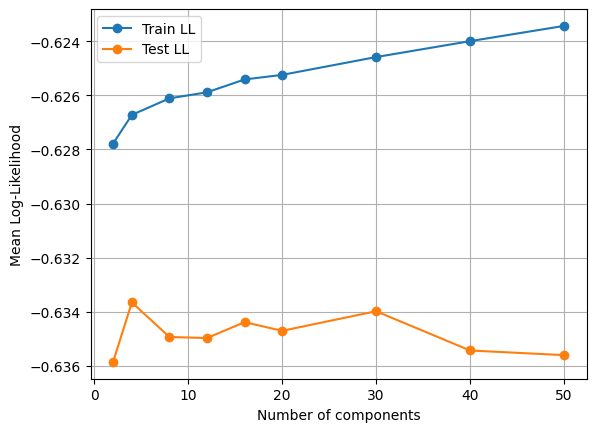

In [30]:

# Split the data into training and testing sets

std_prop = df_error.loc['Crown height', 'pred_error']*0.6

df_crown_height = np.random.normal(df_trait[['Crown height']].values, std_prop)

train_data, test_data = train_test_split(df_crown_height, test_size=0.3, random_state=123)

train_ll = []
test_ll = []

components_range  = [2,4,8,12,16,20,30,40,50]

for n_components in components_range:
    # Fit GMM on training data
    gmm_train = GaussianMixture(n_components=n_components, random_state=0, n_init=3)
    gmm_train.fit(train_data)
    # Log-likelihood on training data
    train_log_likelihood = gmm_train.score(train_data)
    train_ll.append(train_log_likelihood)
    
    # see score in test data
    test_log_likelihood = gmm_train.score(test_data)
    test_ll.append(test_log_likelihood)

    print(f'Number of components: {n_components}, Train LL: {train_log_likelihood}, Test LL: {test_log_likelihood}')

# Plotting Log-Likelihoods
plt.figure()

plt.plot(components_range, train_ll, label='Train LL', marker='o')
plt.plot(components_range, test_ll, label='Test LL', marker='o')
# plt.title('Log-Likelihood for Training and Testing Sets')
plt.xlabel('Number of components')
plt.ylabel('Mean Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()


## GMM in 2D

In [11]:
# df_trait_1000 = df_trait.sample(1000)
# for c1 in df_trait.columns:
#     for c2 in df_trait.columns:
#         # with some probability plot the scatter plot of those 2 traits
#         if np.random.rand() > 0.9:
#             print(c1, c2)
#             df_trait_1000.plot.scatter(x=c1, y=c2, alpha=0.5, s=5)
#             # reset
#             plt.show()


In [14]:
# see which one have more variance
# print(df_trait.var())

traits_2d = ['Specific leaf area', 'Stem diameter']
errors_2d = df_error.loc[traits_2d, 'pred_error']

# get a sample of 100 species
df_trait_sample = df_trait.copy()
df_trait_sample = df_trait_sample[traits_2d]

# resample each observation with mean its real value and errors_2d
df_trait_sample = np.random.normal(df_trait_sample, errors_2d*0.5)

# as dataframe
df_trait_sample = pd.DataFrame(df_trait_sample, columns=traits_2d)

<Axes: xlabel='Specific leaf area', ylabel='Stem diameter'>

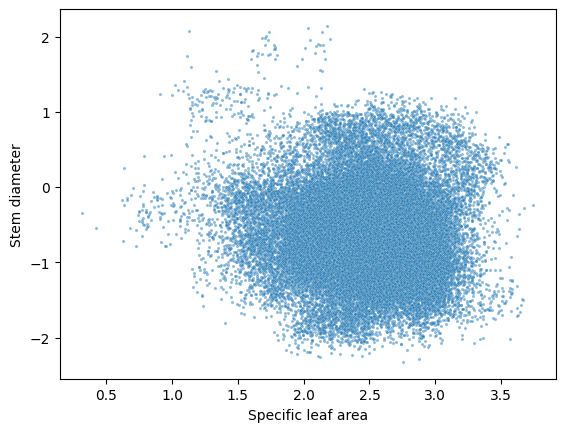

In [15]:


sns.scatterplot(x=traits_2d[0], y=traits_2d[1], data=df_trait_sample,
                s = 5, alpha = 0.5)

BIC for 2 components: 122409.48749533492
BIC for 3 components: 122028.55714062485
BIC for 4 components: 121703.05385192455
BIC for 5 components: 121656.84571495237
BIC for 6 components: 121398.03568147459
BIC for 7 components: 121399.0093984632


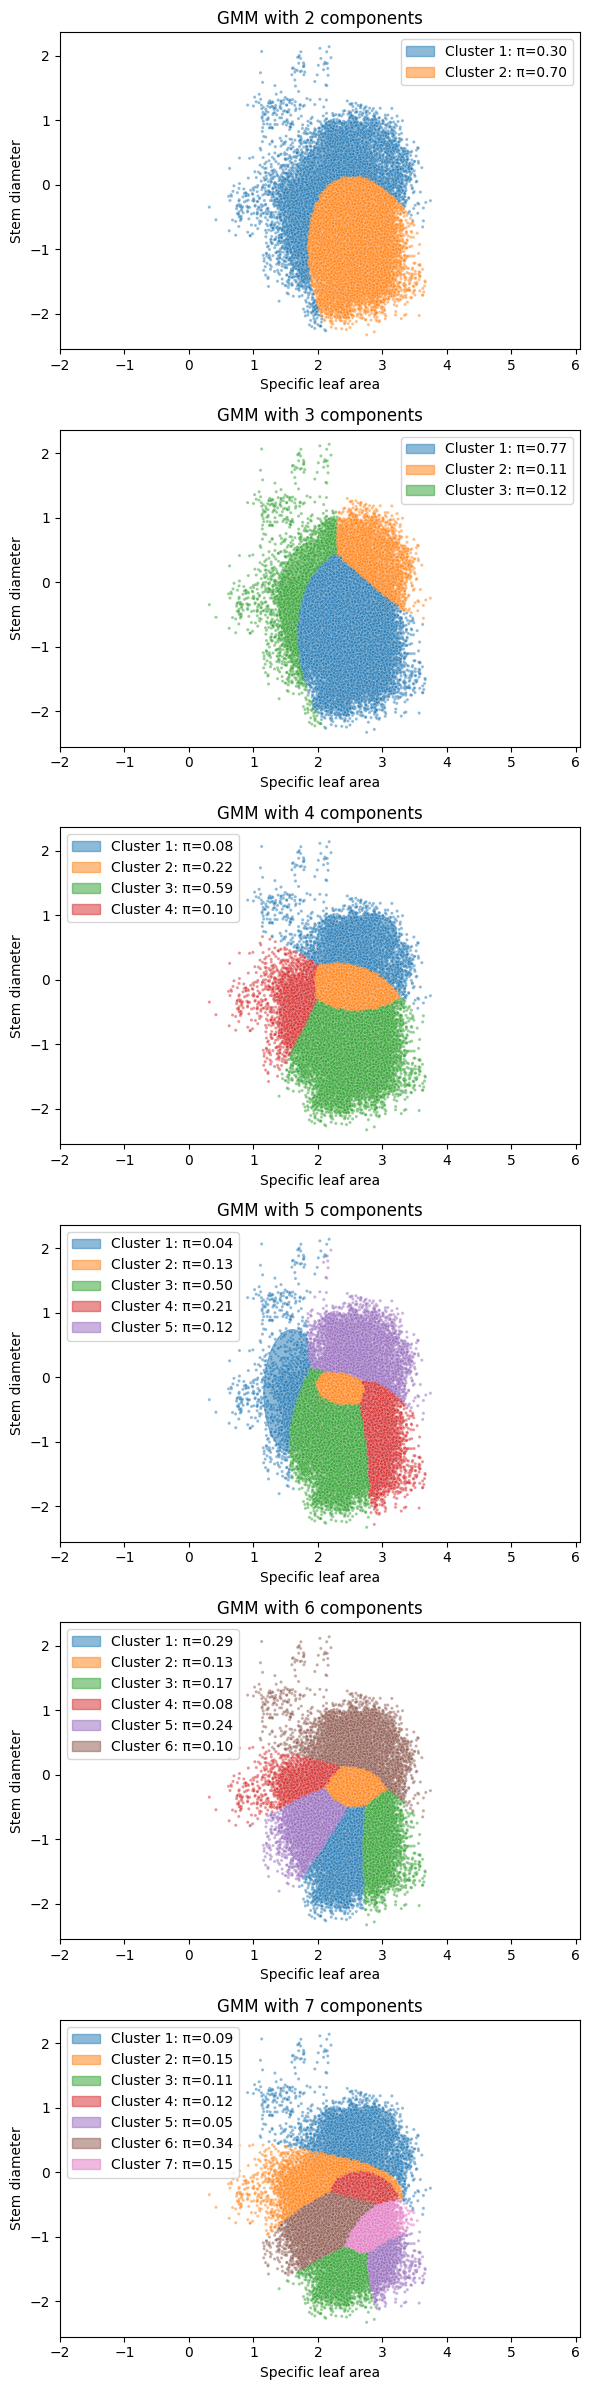

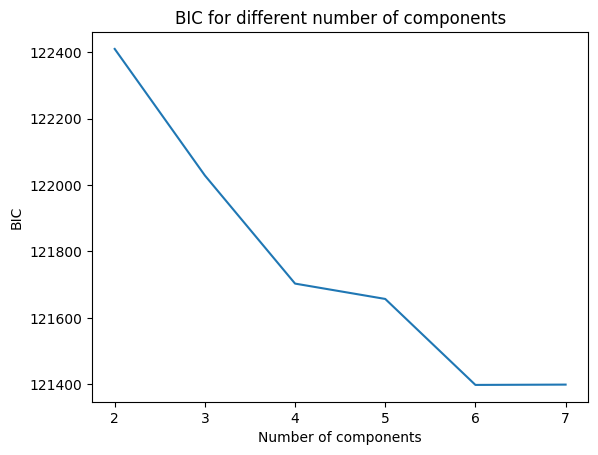

In [16]:
from matplotlib.patches import Ellipse

n_components = [2, 3, 4, 5, 6, 7]
bic_list = []

# Create a figure to hold all subplots
fig, axes = plt.subplots(len(n_components), 1, figsize=(6, 4 * len(n_components)))

for i, n in enumerate(n_components):
    gmm = GaussianMixture(n_components=n, random_state=0, n_init=10, covariance_type='full',
                          init_params='random_from_data', verbose=0)
    gmm.fit(df_trait_sample[traits_2d])
    df_trait_sample['cluster'] = gmm.predict(df_trait_sample[traits_2d])
    bic = gmm.bic(df_trait_sample[traits_2d])
    print(f'BIC for {n} components: {bic}')
    bic_list.append(bic)

    # Select the appropriate axes for this subplot
    ax = axes[i] if len(n_components) > 1 else axes

    # Get means, covariances and weights
    means_n = gmm.means_
    covs_n = gmm.covariances_
    weights_n = gmm.weights_
    color_iter = sns.color_palette("tab10", n)
    # print(f'Weights for {n} components: {weights_n}')

    # Plot each component
    for ix in range(n):
        v, w = np.linalg.eig(covs_n[ix])
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180.0 * angle / np.pi  # Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ellipse = Ellipse(means_n[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix],
                          alpha=0.5, label=f'Cluster {ix+1}: π={weights_n[ix]:.2f}')
        ellipse.set_clip_box(ax.bbox)
        ax.add_artist(ellipse)
        ax.legend()

    sns.scatterplot(x=traits_2d[0], y=traits_2d[1], data=df_trait_sample, s=5, alpha=0.5,
                    hue='cluster', palette='tab10', ax=ax, legend=False)
    ax.axis('equal')
    ax.set_title(f'GMM with {n} components')

plt.tight_layout()
plt.show()

# Plot BIC
plt.figure()
plt.plot(n_components, bic_list)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for different number of components')
plt.show()

BIC for 2 components: 122409.48749533492
Weights for 2 components: [0.30088072 0.69911928]


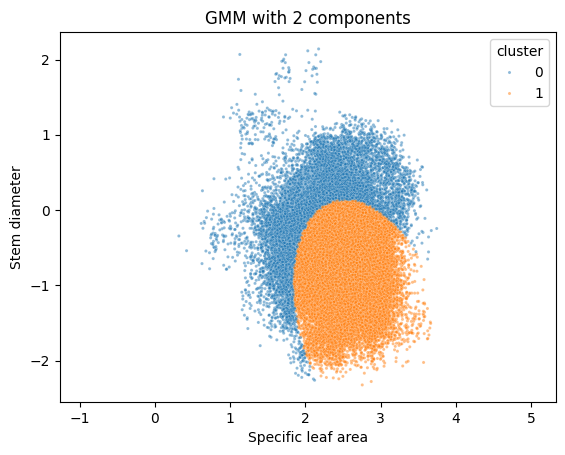

BIC for 3 components: 121985.12964894142
Weights for 3 components: [0.47893546 0.38869463 0.13236992]


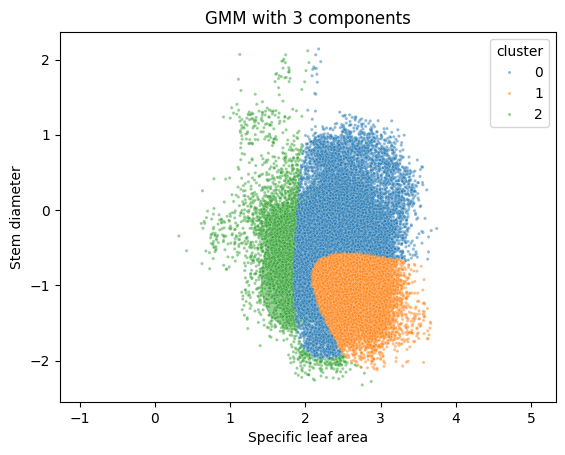

BIC for 4 components: 121535.49568673345
Weights for 4 components: [0.37465132 0.32670623 0.06602813 0.23261433]


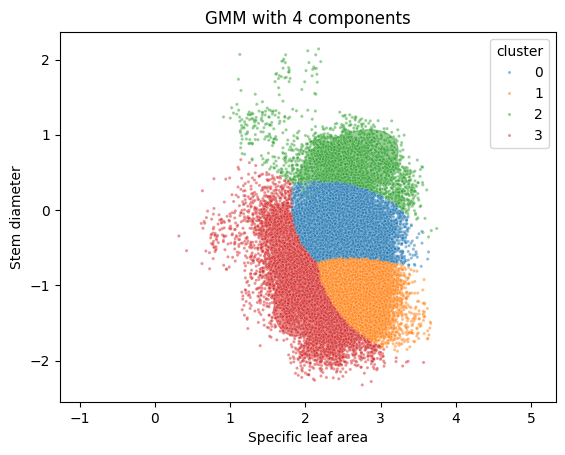

BIC for 5 components: 121395.00481487982
Weights for 5 components: [0.33923405 0.33201156 0.06572853 0.20204645 0.06097942]


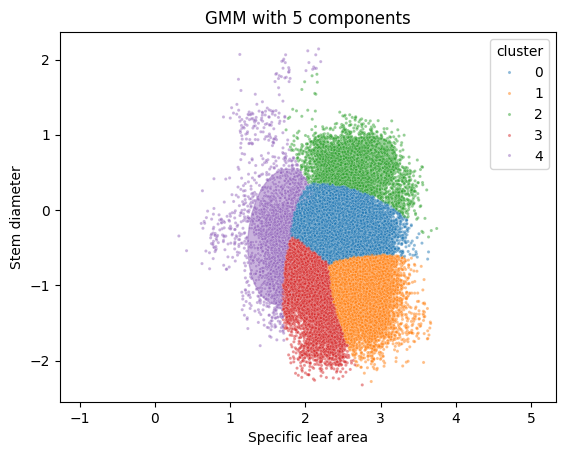

BIC for 6 components: 121207.26735151833
Weights for 6 components: [0.30410396 0.17745858 0.108725   0.29547654 0.05121737 0.06301854]


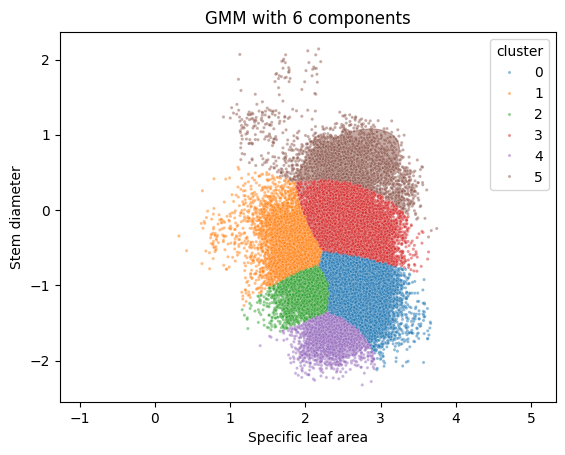

BIC for 7 components: 121124.14252427535
Weights for 7 components: [0.29297048 0.14715729 0.10844239 0.14721837 0.05022228 0.06638198
 0.18760719]


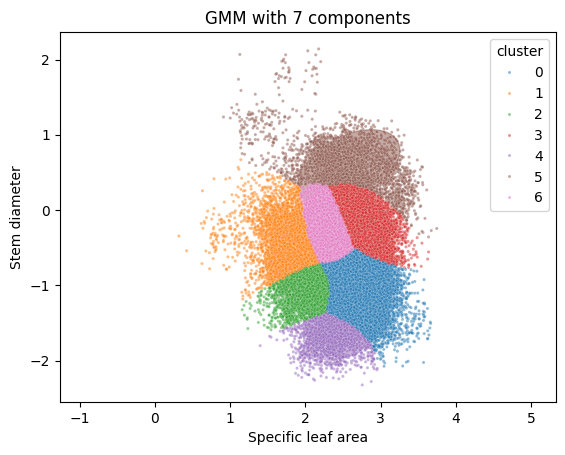

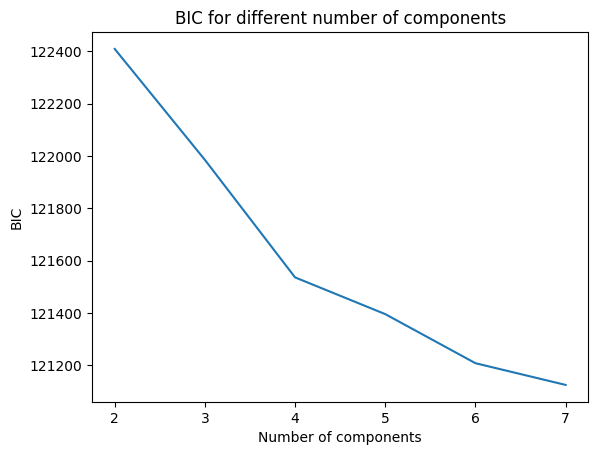

In [17]:

from matplotlib.patches import Ellipse

# Assuming df_trait_sample and traits_2d are properly defined

n_components = [2, 3, 4, 5, 6, 7]
bic_list = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0, n_init=50, covariance_type='full',
                          init_params='random_from_data', verbose = 0)
    gmm.fit(df_trait_sample[traits_2d])
    df_trait_sample['cluster'] = gmm.predict(df_trait_sample[traits_2d])
    bic = gmm.bic(df_trait_sample[traits_2d])
    print(f'BIC for {n} components: {bic}')
    bic_list.append(bic)

    fig, ax = plt.subplots()

    # Get means and covariances
    means_n = gmm.means_
    covs_n = gmm.covariances_
    weights_n = gmm.weights_
    color_iter = sns.color_palette("tab10", n)
    # print weights_n
    print(f'Weights for {n} components: {weights_n}')

    # Plot each component
    for ix in range(n):
        v, w = np.linalg.eig(covs_n[ix])
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180.0 * angle / np.pi  # Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ellipse = Ellipse(means_n[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix], alpha=0.5)
        ellipse.set_clip_box(ax.bbox)
        ax.add_artist(ellipse)

    sns.scatterplot(x=traits_2d[0], y=traits_2d[1], data=df_trait_sample,
                     s=5, alpha=0.5, hue='cluster', palette='tab10', ax=ax)
    plt.axis('equal')
    plt.title(f'GMM with {n} components')
    plt.show()

# Plot BIC
plt.figure()
plt.plot(n_components, bic_list)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for different number of components')
plt.show()


BIC for 2 components: 122409.48749533492
Weights for 2 components: [0.30088072 0.69911928]


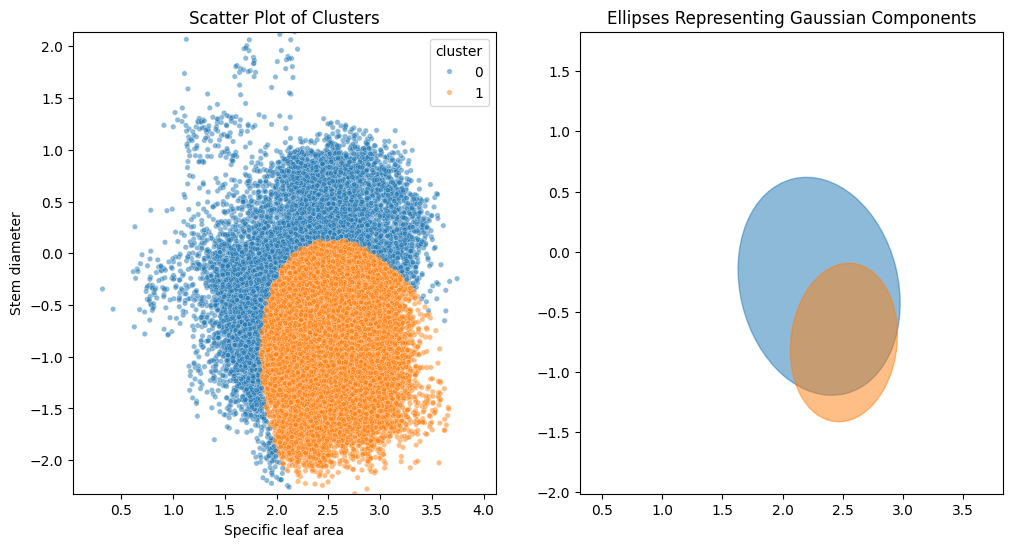

BIC for 3 components: 122186.25205335247
Weights for 3 components: [0.21347177 0.40104945 0.38547878]


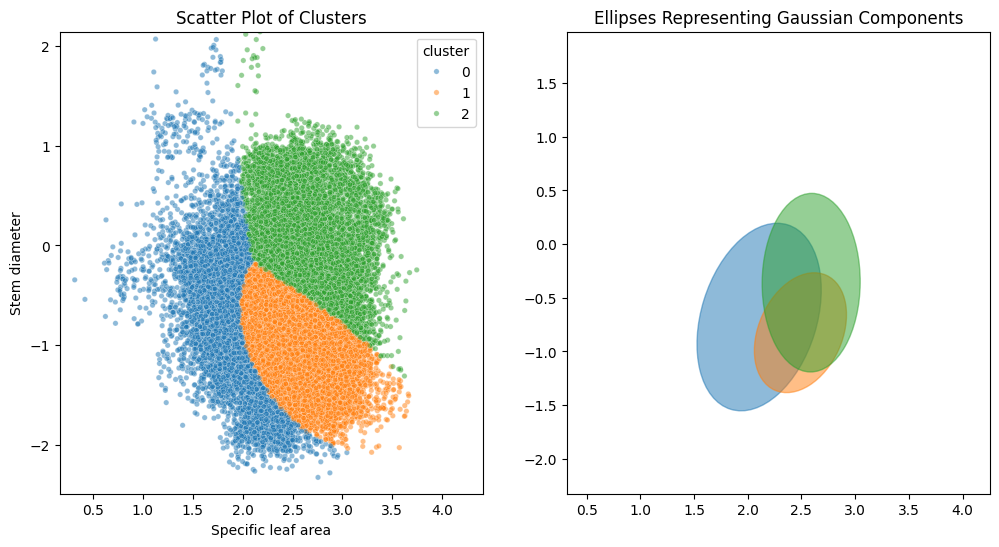

BIC for 4 components: 122290.14049857807
Weights for 4 components: [0.19824683 0.19372016 0.3126435  0.29538951]


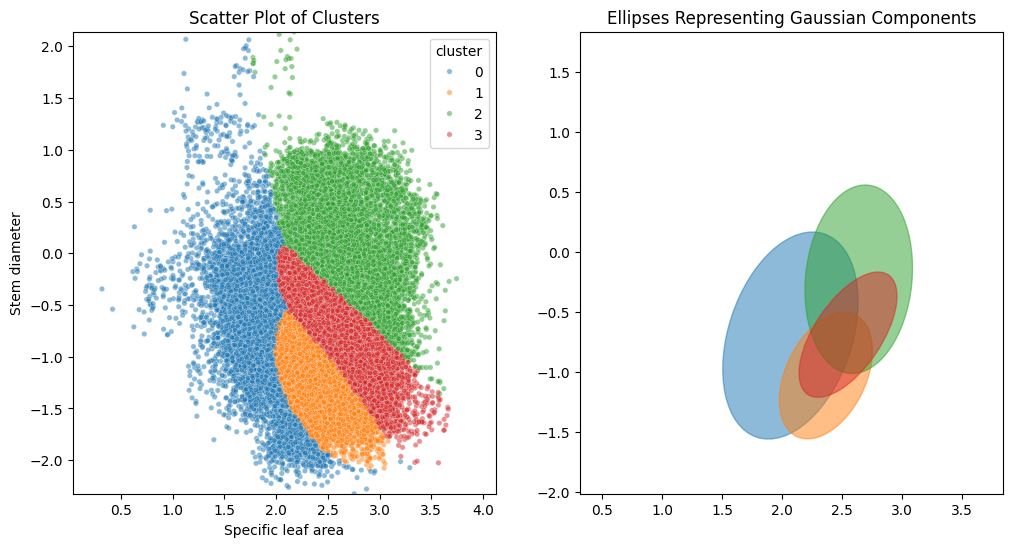

BIC for 5 components: 122203.8125609971
Weights for 5 components: [0.1127193  0.17253246 0.10841731 0.17223782 0.43409311]


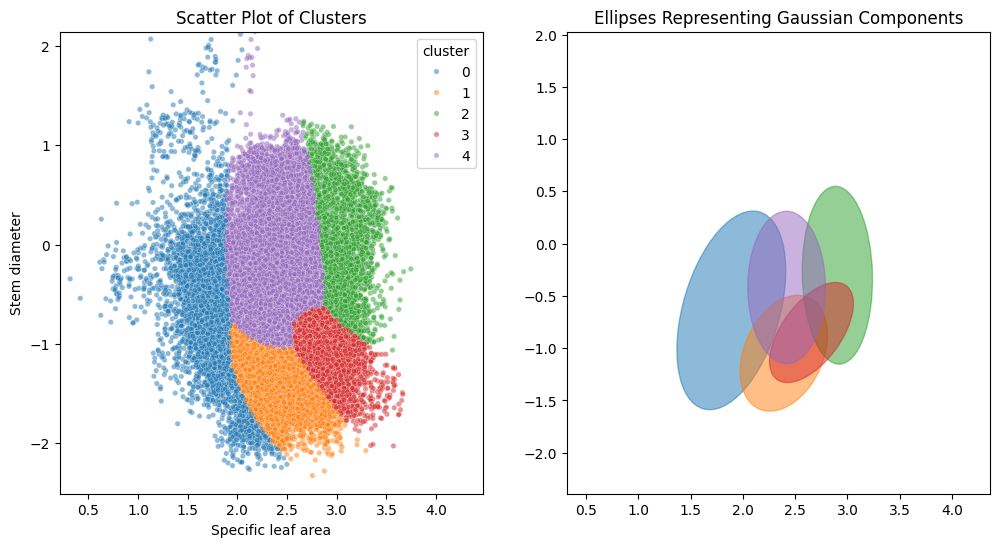

BIC for 6 components: 121647.48244469454
Weights for 6 components: [0.12232616 0.21100283 0.06066489 0.17497517 0.27232122 0.15870973]


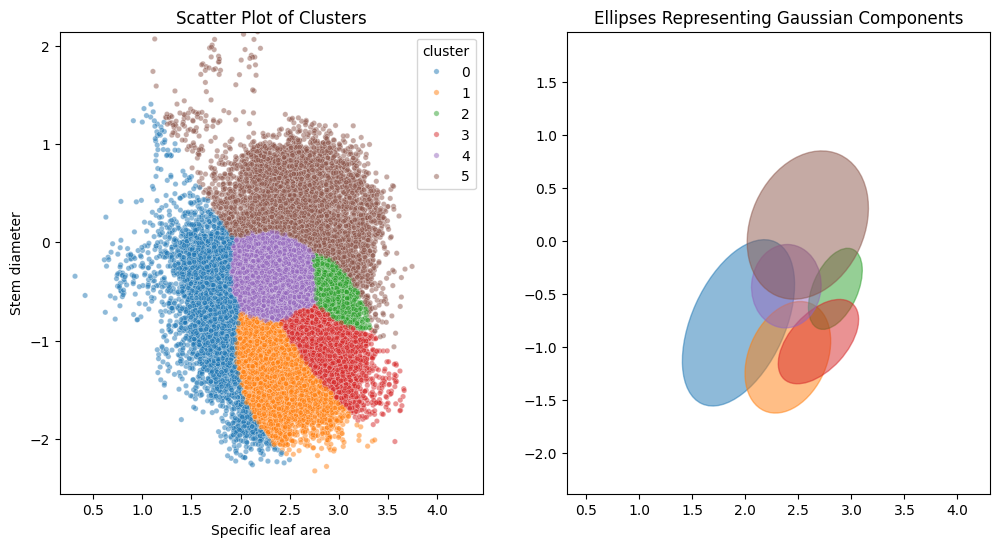

BIC for 7 components: 121597.65738299655
Weights for 7 components: [0.11093273 0.20982934 0.0615021  0.18322236 0.24683419 0.13432688
 0.05335239]


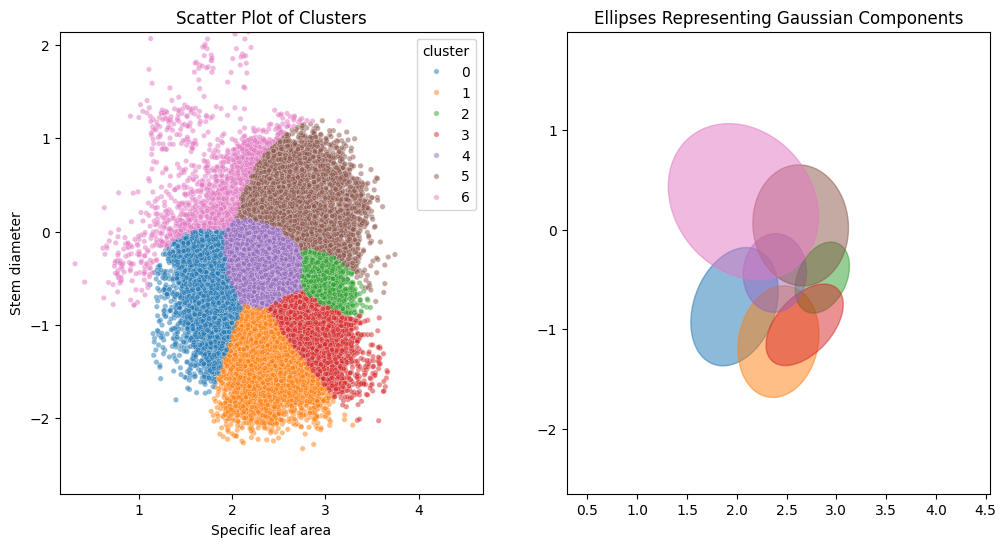

BIC for 8 components: 121312.6362270642
Weights for 8 components: [0.11137185 0.21070255 0.06268015 0.18325706 0.24243069 0.11381318
 0.02703776 0.04870676]


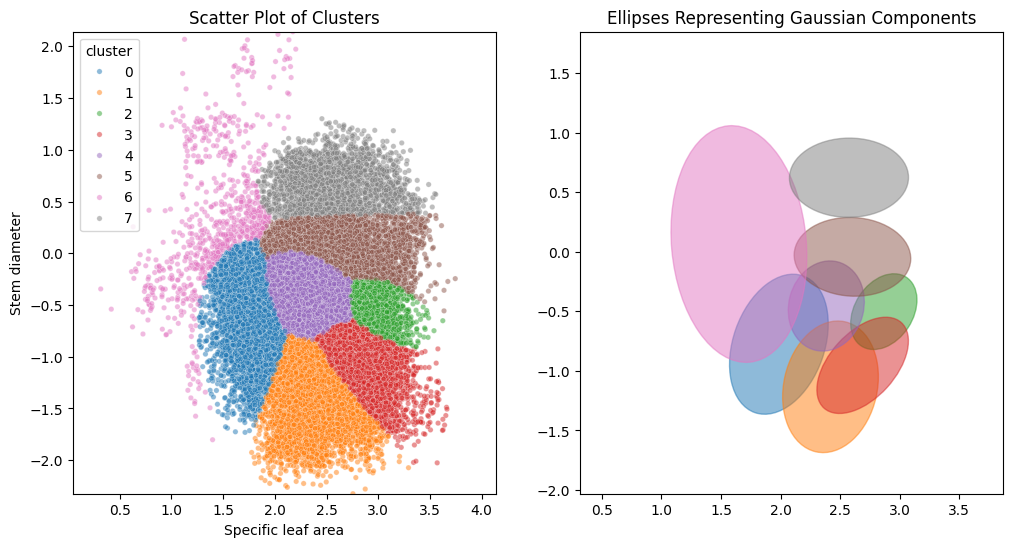

BIC for 9 components: 121424.93411396291
Weights for 9 components: [0.10288728 0.21560732 0.06106219 0.19862345 0.13183148 0.08775745
 0.02688277 0.05161785 0.1237302 ]


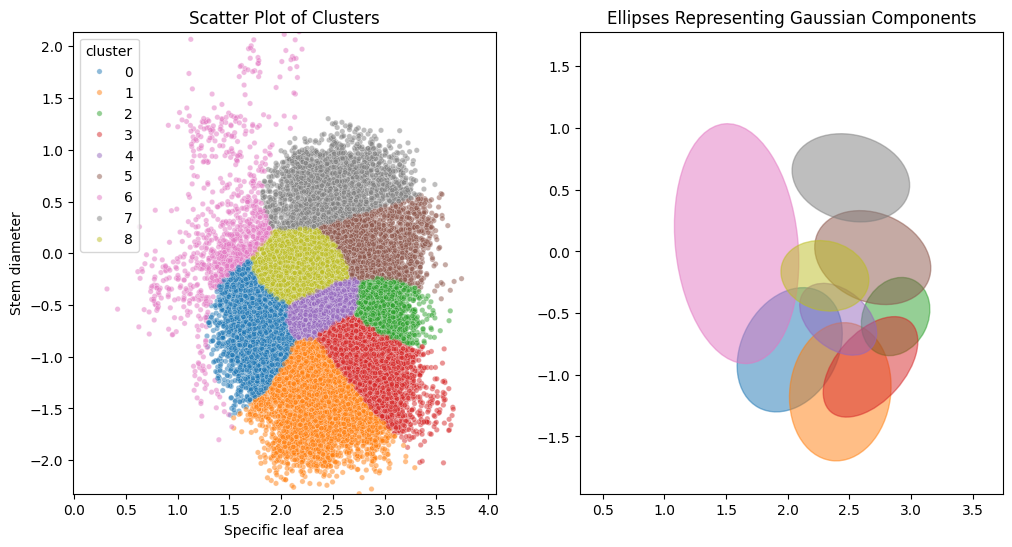

BIC for 10 components: 121140.3104331089
Weights for 10 components: [0.10792667 0.14226226 0.06302501 0.17334455 0.14619798 0.09121757
 0.02651801 0.05173422 0.13194767 0.06582606]


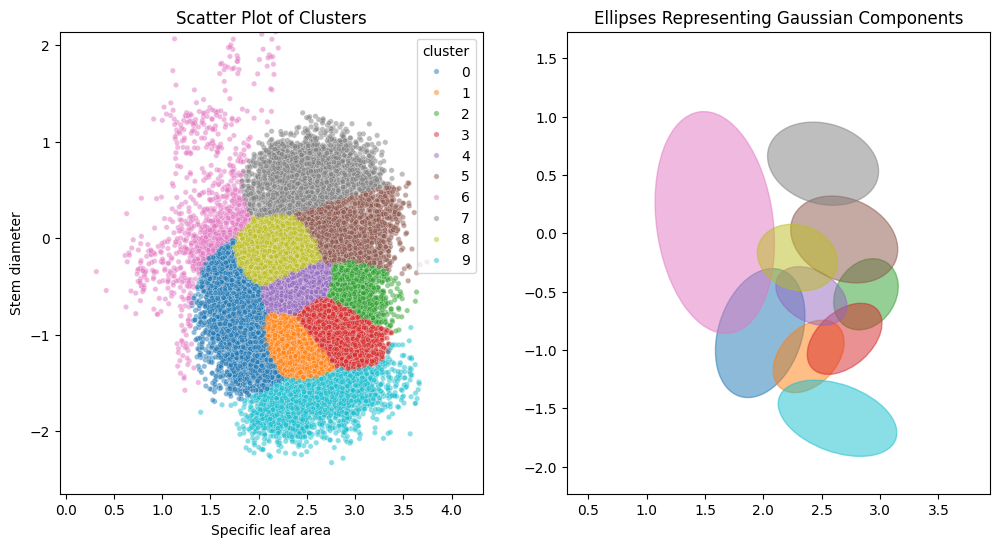

In [20]:
for n in [2,3,4,5,6,7,8,9,10]:
    gmm = GaussianMixture(n_components=n, random_state=0, n_init=1, covariance_type='full',
                          init_params='random_from_data')
    gmm.fit(df_trait_sample[traits_2d])
    df_trait_sample['cluster'] = gmm.predict(df_trait_sample[traits_2d])
    bic = gmm.bic(df_trait_sample[traits_2d])
    print(f'BIC for {n} components: {bic}')
    bic_list.append(bic)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Get means and covariances
    means_n = gmm.means_
    covs_n = gmm.covariances_
    weights_n = gmm.weights_
    color_iter = sns.color_palette("tab10", n)
    print(f'Weights for {n} components: {weights_n}')

    # Left plot: Scatter plot of clusters
    sns.scatterplot(x=traits_2d[0], y=traits_2d[1], data=df_trait_sample, s=15, alpha=0.5, hue='cluster', palette='tab10', ax=axs[0])
    axs[0].set_title('Scatter Plot of Clusters')
    axs[0].axis('equal')

    # Plot ellipses and ensure they are scaled and positioned correctly
    for ix in range(n):
        v, w = np.linalg.eig(covs_n[ix])
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180.0 * angle / np.pi  # Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ellipse = Ellipse(means_n[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix], alpha=0.5)
        ellipse.set_clip_box(axs[1].bbox)
        axs[1].add_artist(ellipse)

    # Manually set limits based on combined data extent
    combined_xlim = [min(df_trait_sample[traits_2d[0]].min(), means_n[:, 0].min() - 1 * np.max(v)),
                     max(df_trait_sample[traits_2d[0]].max(), means_n[:, 0].max() + 1 * np.max(v))]
    combined_ylim = [min(df_trait_sample[traits_2d[1]].min(), means_n[:, 1].min() - 1 * np.max(v)),
                     max(df_trait_sample[traits_2d[1]].max(), means_n[:, 1].max() + 1 * np.max(v))]

    axs[0].set_xlim(combined_xlim)
    axs[0].set_ylim(combined_ylim)
    axs[1].set_xlim(combined_xlim)
    axs[1].set_ylim(combined_ylim)

    axs[1].set_title('Ellipses Representing Gaussian Components')
    axs[1].axis('equal')

    plt.show()

# # Plot BIC
# plt.figure()
# plt.plot(n_components, bic_list)
# plt.xlabel('Number of components')
# plt.ylabel('BIC')
# plt.title('BIC for different number of components')
# plt.show()

BIC for 2 components: 21652.06186914154


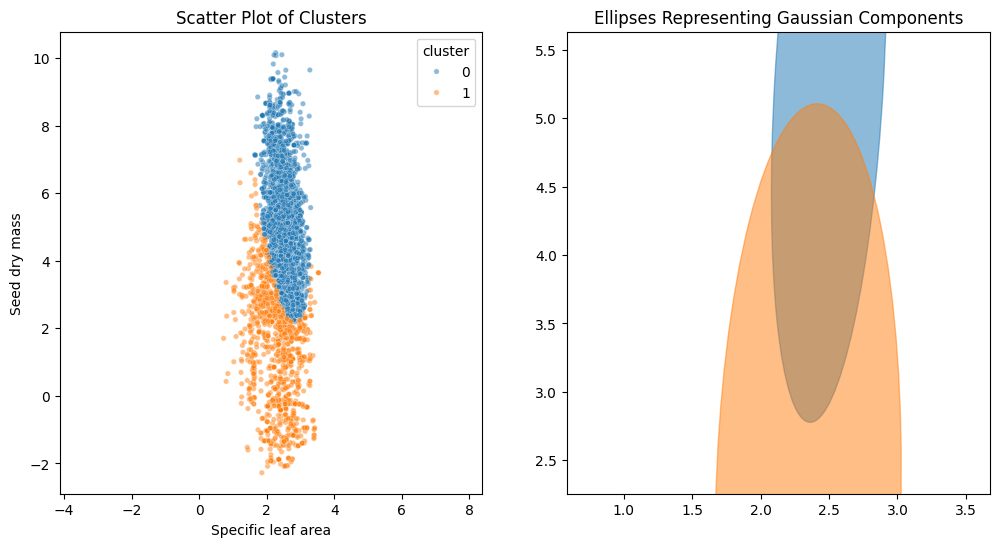

BIC for 3 components: 21625.27872198431


BIC for 4 components: 21643.36808578598


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

# Assuming df_trait_sample and traits_2d are properly defined

n_components = [2, 3, 4]
bic_list = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0, n_init=100, covariance_type='full')
    gmm.fit(df_trait_sample[traits_2d])
    df_trait_sample['cluster'] = gmm.predict(df_trait_sample[traits_2d])
    bic = gmm.bic(df_trait_sample[traits_2d])
    print(f'BIC for {n} components: {bic}')
    bic_list.append(bic)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Get means and covariances
    means_n = gmm.means_
    covs_n = gmm.covariances_
    color_iter = sns.color_palette("tab10", n)

    # Left plot: Scatter plot of clusters
    sns.scatterplot(x=traits_2d[0], y=traits_2d[1], data=df_trait_sample, s=15, alpha=0.5, hue='cluster', palette='tab10', ax=axs[0])
    axs[0].set_title('Scatter Plot of Clusters')
    axs[0].axis('equal')

    # Right plot: Ellipses for each Gaussian component
    for ix in range(n):
        v, w = np.linalg.eig(covs_n[ix])
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180.0 * angle / np.pi  # Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ellipse = Ellipse(means_n[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix], alpha=0.5)
        ellipse.set_clip_box(axs[1].bbox)
        axs[1].add_artist(ellipse)
        axs[1].set_xlim(axs[0].get_xlim())
        axs[1].set_ylim(axs[0].get_ylim())

    axs[1].set_title('Ellipses Representing Gaussian Components')
    axs[1].axis('equal')

    plt.show()

# Plot BIC
plt.figure()
plt.plot(n_components, bic_list)
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for different number of components')
plt.show()
